# DATA 620 Final Project
Naomi Buell and Richie Rivera

## Introduction
This project seeks to answer the research question: **What factors influence user reviews for Steam video games?** Steam is a popular digital distribution platform for video games, and user reviews play a significant role in shaping the perception and success of games on the platform. Understanding the factors that influence these reviews can provide valuable insights for game developers, marketers, and the gaming community.

For our project, we'll analyze Steam game reviews for some of the top 100 best selling games to explore how factors such as game genre, release date, and user demographics impact reviews. We'll use web scraping techniques to collect review data from Steam's platform, followed by data cleaning and preprocessing to ensure the dataset is suitable for analysis. With our data cleaned up, we’ll perform a network analysis on reviewers to see if there are any “super” reviewers among them who may influence the overall sentiment.

## Setting up the Environment

Importing libraries below.

In [26]:
import requests
import json
from datetime import datetime
import time
from concurrent.futures import ThreadPoolExecutor
import os
import pickle
import zipfile
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import networkx as nx
from networkx.algorithms import bipartite as bi
import io
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import math

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nbuell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data acquisition

### Set up data acquisition helper functions

First, we create two functions to help with file storage. 

In [2]:
def zip_json_files_in_directory(directory_path):
    """
    Zips every .json file found in the specified directory into its own individual .zip archive.

    Args:
        directory_path (str): The absolute or relative path to the directory containing files to be zipped.

    Returns:
        int: The count of .json files successfully zipped.
    """
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at path: {directory_path}")
        return 0

    zip_count = 0
    
    # Iterate over all entries in the directory
    for item_name in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item_name)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            
            # --- NEW LOGIC: Check for .json extension ---
            base_name, extension = os.path.splitext(item_name)
            
            if extension.lower() == '.json':
                
                # Define the output zip filename
                # Example: 'app_730.json' becomes 'app_730.zip'
                zip_filename = os.path.join(directory_path, f"{base_name}.zip")
                
                # Check if the zip file already exists to potentially skip or overwrite
                if os.path.exists(zip_filename):
                    print(f"Skipping '{item_name}': Zip file already exists.")
                    continue
                    
                try:
                    # Create the individual zip archive
                    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
                        # Add the original file to the archive
                        zf.write(item_path, arcname=item_name)
                    os.remove(item_name)
                    print(f"✅ Zipped '{item_name}' to '{os.path.basename(zip_filename)}'")
                    zip_count += 1
                    
                except Exception as e:
                    print(f"❌ Failed to zip {item_name}: {e}")
            
    return zip_count

def unzip_all_in_directory(target_directory):
    """
    Unzips all .zip files in a given directory to new subdirectories
    with the same name as the zip file (excluding the extension).

    Args:
        target_directory (str): The path to the directory containing the .zip files.
    """
    if not os.path.isdir(target_directory):
        print(f"Error: Directory '{target_directory}' does not exist.")
        return

    print(f"Searching for .zip files in: {target_directory}")
    for filename in os.listdir(target_directory):
        if filename.endswith(".zip"):
            zip_filepath = os.path.join(target_directory, filename)
            # Create a directory name based on the zip file name (without .zip)
            extracted_dir_name = os.path.splitext(filename)[0]
            extracted_dir_path = os.path.join(target_directory, extracted_dir_name)

            # Create the extraction directory if it doesn't exist
            os.makedirs(extracted_dir_path, exist_ok=True)

            try:
                with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                    zip_ref.extractall(extracted_dir_path)
                print(f"Successfully extracted '{filename}' to '{extracted_dir_name}/'")
            except zipfile.BadZipFile:
                print(f"Error: '{filename}' is not a valid zip file.")
            except Exception as e:
                print(f"An error occurred while extracting '{filename}': {e}")

We'll also create functions that will pull 100 reviews at a time. We access reviews through Steam's [User Reviews API](https://partner.steamgames.com/doc/store/getreviews).

In [3]:
def fetch_review_page(appid, cursor, start_date_timestamp, num_per_page, review_type, language):
    """
    Helper function to fetch a single page of Steam reviews for concurrent execution.
    Returns a tuple of (reviews, next_cursor, should_stop).
    """
    url = f"https://store.steampowered.com/appreviews/{appid}"
    params = {
        'json': 1,
        'filter': 'recent',
        'language': language,
        'review_type': review_type,
        'num_per_page': num_per_page,
        'cursor': cursor
    }

    try:
        response = requests.get(url, params=params, stream=True)
        response.raise_for_status()
        data = response.json()

        if data.get('success') != 1:
            return ([], None, True) # API call failed

        reviews = data.get('reviews', [])
        next_cursor = data.get('cursor')
        
        if reviews:
            # The API is filtered by 'recent', so the first review is usually the youngest.
            # We explicitly check the max just in case, but rely on the first element.
            youngest_timestamp = reviews[0].get('timestamp_created')
            if youngest_timestamp:
                youngest_date = datetime.fromtimestamp(youngest_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                print(f"Latest review date found on this page: {youngest_date}")
        
        filtered_reviews = []
        should_stop = False

        for review in reviews:
            review_timestamp = review.get('timestamp_created')
            
            # Stop if we find a review older than the target date
            if review_timestamp and review_timestamp < start_date_timestamp:
                should_stop = True
                break
            
            filtered_reviews.append(review)
        
        return (filtered_reviews, next_cursor, should_stop)

    except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
        print(f"An error occurred fetching cursor {cursor[:10]}: {e}")
        return ([], None, True)

Then, we create a second function that'll allow us to pull these reviews in parallel.

In [4]:
def get_steam_reviews_from_2025(appid, num_per_page=100, review_type='all', language='english', max_workers=10, verbose=False):
    """
    Retrieves all user reviews for a Steam App ID posted from January 1st, 2025 onward,
    using concurrent requests.
    """
    all_reviews = []
    
    # Define a fixed start date timestamp (January 1st, 2025)
    start_date = datetime(2025, 1, 1)
    start_date_timestamp = start_date.timestamp()

    if verbose:
        print(f"Starting to fetch reviews for App ID {appid}. Looking for reviews newer than {start_date.strftime('%Y-%m-%d')}.")

    # Cursors to be fetched. Start with the initial cursor '*'.
    cursors_to_fetch = ['*']
    
    # Cursors that are currently being processed or scheduled.
    scheduled_cursors = set()
    
    # We will use a flag to signal when we've hit the chronological limit
    stop_fetching = False

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        
        futures = {} # Maps future objects to the cursor they are processing

        while cursors_to_fetch or futures:
            
            # 1. Schedule new jobs up to the max_workers limit
            while cursors_to_fetch and len(futures) < max_workers:
                cursor = cursors_to_fetch.pop(0)
                if cursor not in scheduled_cursors:
                    if verbose:
                        print(f"Scheduling page with cursor: {cursor[:10]}...")
                    future = executor.submit(
                        fetch_review_page, 
                        appid, cursor, start_date_timestamp, num_per_page, review_type, language
                    )
                    futures[future] = cursor
                    scheduled_cursors.add(cursor) # Mark as scheduled

            # If no jobs are scheduled and none are running, break
            if not futures:
                break
                
            # 2. Process results as they complete
            completed_futures = []
            for future in futures:
                if future.done():
                    try:
                        reviews, next_cursor, should_stop_page = future.result()
                        
                        if should_stop_page:
                            stop_fetching = True
                            
                        # Only append if we haven't hit the overall stop flag
                        if not stop_fetching:
                            all_reviews.extend(reviews)
                            
                        # If a next cursor is provided, and we're not stopping, add it to the queue
                        if next_cursor and not stop_fetching and next_cursor not in scheduled_cursors:
                            cursors_to_fetch.append(next_cursor)
                        
                        if verbose:
                            print(f"Page processed. Total reviews: {len(all_reviews)}. Next cursor: {next_cursor[:10] if next_cursor else 'None'}. Stop flag: {should_stop_page}")

                    except Exception as e:
                        print(f"Job failed for cursor {futures[future][:10]}: {e}")
                    
                    completed_futures.append(future)
            
            # Remove completed jobs from the dictionary
            for future in completed_futures:
                del futures[future]

            if stop_fetching:
                print("Chronological limit reached by a worker. Shutting down executor.")
                # Cancel pending jobs and stop scheduling new ones
                for future in futures:
                    future.cancel()
                break

            # Add a small delay to avoid busy-waiting, but be mindful of Steam's rate limit
            # Note: Parallel fetching already means higher rate, so the inherent delay 
            # while waiting for results helps, but we might need a more controlled throttling 
            # if this were a production system.
            time.sleep(0.001)

    return all_reviews

In order to get our data, we'll first need to get all the Steam App IDs. We can do this by pulling from the [Steam app API](https://partner.steamgames.com/doc/store/application).

In [5]:
def get_all_steam_appids():
    """
    Fetches the list of all Steam applications and their App IDs using the
    GetAppList API endpoint.
    
    Returns:
        list: A list of dictionaries, where each dict has keys 'appid' and 'name'.
        Returns an empty list if the API call fails.
    """
    url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
    
    print("Fetching complete list of all Steam applications. This may take a moment...")
    
    try:
        # Steam's GetAppList is a public, unauthenticated endpoint
        response = requests.get(url, timeout=30)
        response.raise_for_status() # Raise an exception for bad status codes
        
        data = response.json()
        
        # Navigate the JSON structure to the list of apps
        apps = data.get('applist', {}).get('apps', [])
        
        print(f"Successfully retrieved {len(apps):,} applications.")
        return apps
        
    except requests.exceptions.RequestException as e:
        print(f"API request failed: {e}")
        return []
    except json.JSONDecodeError:
        print("Failed to decode JSON response.")
        return []

In [6]:
def check_zip_file_count(directory, extension, threshold):
    """
    Counts files with a specific extension in a directory and checks if
    the count is greater than or equal to a given threshold.

    Args:
        directory (str): The path to the directory to check.
        extension (str): The file extension to count (e.g., '.zip').
        threshold (int): The number to compare the count against.

    Returns:
        bool: True if file count >= threshold, False otherwise.
              Returns False if directory not found or error occurs.
    """
    try:
        # Ensure the directory exists
        if not os.path.isdir(directory):
            print(f"Error: Directory '{directory}' not found or is not a directory.")
            return False  # Return False on error

        # Normalize extension (ensure it starts with a dot and compare case-insensitively)
        if not extension.startswith('.'):
            extension = '.' + extension
        extension = extension.lower()

        # Count files with the requested extension in the directory
        zip_files_count = sum(
            1
            for f in os.listdir(directory)
            if f.lower().endswith(extension) and os.path.isfile(os.path.join(directory, f))
        )

        print(f"Found {zip_files_count} '{extension}' files in '{directory}'.")

        # Return True when the count meets or exceeds the threshold
        return zip_files_count >= threshold

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False # Return False on exception

### Download review data

Once we have the App IDs, we can then use those to pull the reviews for each game.

In order to make sure we don't do this more than necessary, we'll save the App IDs to a file so we can reuse them later.

> Richie: There is something wrong here where the app_id_to_name_map is not being created. Do you know how to fix this haha?

In [7]:
# Check if we already have the files. If so then don't do anything
if not check_zip_file_count('data/', '.zip', 100):

    # Read in the pickled list of Steam App IDs of the top 100 games
    with open('top_100_steam_app_ids.pkl', 'rb') as f:
        top_100 = pickle.load(f)

    # Fetch the complete list of Steam applications
    app_id_list = get_all_steam_appids()

    # Create a mapping of app IDs to names for easy reference
    app_id_to_name_map = {}

    # Iterate over all Steam apps and fetch reviews for the top 100
    for steam_app in app_id_list:
        # Map the app ID to its name
        app_id_to_name_map[steam_app['appid']] = steam_app['name']

        # Skip apps not in the top 100
        if steam_app['appid'] not in top_100:
            continue
        else:
            
            # Prepare the save filepath
            save_filename = f"{steam_app['appid']}.json"
            save_filepath = f"data/{save_filename}"
            zip_filepath = f"data/{steam_app['appid']}.zip"

            print(zip_filepath)
            
            # Check if the file already exists
            if os.path.exists(save_filepath):
                print(f"Game \"{steam_app['name']}\" data already available. Skipping.")
            
            # Check if the zip version of the file exists
            elif os.path.exists(zip_filepath):
                print(f"Game \"{steam_app['name']}\" data zipped. Unzipping.")
                zipfile.ZipFile(zip_filepath, 'r').extractall(os.path.dirname(zip_filepath))

            # If not, fetch and save the reviews
            else:
                downloading_print_line = f"Fetching reviews for '{steam_app['name']}"
                
                print(f"\t\t{(len(downloading_print_line)+6)*'*'}\n\t\t*  {downloading_print_line}  *\n\t\t{(len(downloading_print_line)+6)*'*'}")
                reviews = get_steam_reviews_from_2025(
                    appid=steam_app['appid'],
                    num_per_page=100,
                    review_type='all',
                    language='english',
                    verbose=False
                )

                # Save the reviews to a JSON file
                with open(save_filepath, 'w', encoding='utf-8') as f:
                    json.dump(reviews, f, ensure_ascii=False, indent=4)
    zip_json_files_in_directory('data/')
else:
    unzip_all_in_directory('data/')

Found 100 '.zip' files in 'data/'.
Searching for .zip files in: data/
Successfully extracted '1144200.zip' to '1144200/'
Successfully extracted '739630.zip' to '739630/'
Successfully extracted '2050650.zip' to '2050650/'
Successfully extracted '1466860.zip' to '1466860/'
Successfully extracted '1151340.zip' to '1151340/'
Successfully extracted '1222670.zip' to '1222670/'
Successfully extracted '2870920.zip' to '2870920/'
Successfully extracted '2399830.zip' to '2399830/'
Successfully extracted '1857950.zip' to '1857950/'
Successfully extracted '3681810.zip' to '3681810/'
Successfully extracted '1237320.zip' to '1237320/'
Successfully extracted '1808500.zip' to '1808500/'
Successfully extracted '1085660.zip' to '1085660/'
Successfully extracted '311210.zip' to '311210/'
Successfully extracted '1984270.zip' to '1984270/'
Successfully extracted '1159690.zip' to '1159690/'
Successfully extracted '2062430.zip' to '2062430/'
Successfully extracted '3364070.zip' to '3364070/'
Successfully ext

With all of our data downloaded, we can load it into memory for analysis.

In [8]:
all_reviews_data = []
search_path = 'data/*/*.json'

# Use glob to find all files matching the pattern
for filepath in glob.glob(search_path):
    # Extract the App ID from the filename for better logging
    filename = os.path.basename(filepath)
    app_id = filename.split('.')[0]
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Each file contains a list of review dictionaries, so we extend the master list
            reviews_list = json.load(f)
            
            # Optional: Add the app_id directly to each review dictionary for later network analysis
            for review in reviews_list:
                review['game_appid'] = app_id
            
            all_reviews_data.extend(reviews_list)
            
            print(f"Loaded {len(reviews_list):,} reviews from App ID {app_id}")
            
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {filename}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")

Loaded 5,469 reviews from App ID 2062430
Loaded 0 reviews from App ID 1973530
Loaded 2,063 reviews from App ID 2968420
Loaded 563 reviews from App ID 2879840
Loaded 8,899 reviews from App ID 311210
Loaded 0 reviews from App ID 1172470
Loaded 4,600 reviews from App ID 949230
Loaded 110,580 reviews from App ID 730
Loaded 144 reviews from App ID 3364070
Loaded 288 reviews from App ID 2827200
Loaded 168 reviews from App ID 3880840
Loaded 29,896 reviews from App ID 1245620
Loaded 20,555 reviews from App ID 2592160
Loaded 253 reviews from App ID 3981100
Loaded 2,200 reviews from App ID 440
Loaded 9,199 reviews from App ID 427410
Loaded 33,394 reviews from App ID 322170
Loaded 43,095 reviews from App ID 1144200
Loaded 0 reviews from App ID 238960
Loaded 27,673 reviews from App ID 3405340
Loaded 1,399 reviews from App ID 1237320
Loaded 2,259 reviews from App ID 1857950
Loaded 5,048 reviews from App ID 1984270
Loaded 1,600 reviews from App ID 1527950
Loaded 34,869 reviews from App ID 3240220
Lo

Reviewing some of the data to ensure it loaded correctly.

In [9]:
all_reviews_data[:1]

[{'recommendationid': '208393909',
  'author': {'steamid': '76561197969442060',
   'num_games_owned': 424,
   'num_reviews': 6,
   'playtime_forever': 879,
   'playtime_last_two_weeks': 879,
   'playtime_at_review': 879,
   'last_played': 1762266688},
  'language': 'english',
  'review': 'This game is brick-breaking, rogue-like crack. I only hope they never port this to mobile phones.',
  'timestamp_created': 1762266607,
  'timestamp_updated': 1762266607,
  'voted_up': True,
  'votes_up': 0,
  'votes_funny': 0,
  'weighted_vote_score': 0.5,
  'comment_count': 0,
  'steam_purchase': True,
  'received_for_free': False,
  'written_during_early_access': False,
  'primarily_steam_deck': False,
  'game_appid': '2062430'}]

### Data cleaning and transformation

We convert the list to a pandas data frame and update column types.

In [10]:
# Convert to DataFrame
df = pd.DataFrame(all_reviews_data)

# Expand nested 'author' dict into separate columns
author_expanded = pd.json_normalize(df['author']).add_prefix('author_')
df = pd.concat([df.drop(columns=['author']), author_expanded], axis=1)

# Convert specified timestamp columns to datetime (in-place on df)
for col in ['timestamp_created', 'timestamp_updated', 'timestamp_dev_responded', 'author_last_played']:
    df[col] = pd.to_datetime(df[col], unit='s', errors='coerce')

# Preview data
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,timestamp_dev_responded,developer_response,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,author_deck_playtime_at_review
0,208393909,english,"This game is brick-breaking, rogue-like crack....",2025-11-04 14:30:07,2025-11-04 14:30:07,True,0,0,0.5,0,...,NaT,NaN,76561197969442060,424,6,879,879,879.0,2025-11-04 14:31:28,NaN
1,208391996,english,Really fun and simple game. Reminds me of the ...,2025-11-04 13:58:53,2025-11-04 13:58:53,True,0,0,0.5,0,...,NaT,NaN,76561198303599955,131,14,1704,1704,1644.0,2025-11-04 14:59:28,NaN
2,208391912,english,Just completed all achievements. Incredible g...,2025-11-04 13:57:22,2025-11-04 13:57:22,True,0,0,0.5,0,...,NaT,NaN,76561199873112173,0,1,2554,2554,2548.0,2025-11-04 13:58:38,2548.0
3,208391653,english,It's a simple idea but so incredibly satisfyin...,2025-11-04 13:53:08,2025-11-04 13:53:08,True,0,0,0.5,0,...,NaT,NaN,76561198054508553,0,14,4672,2914,4672.0,2025-11-04 02:38:10,NaN
4,208389506,english,"Got a lot of AAA games in my library, but in t...",2025-11-04 13:17:10,2025-11-04 13:17:10,True,0,0,0.5,0,...,NaT,NaN,76561197991859264,1153,42,2226,2226,2226.0,2025-11-04 13:13:32,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774962 entries, 0 to 1774961
Data columns (total 25 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   recommendationid                object        
 1   language                        object        
 2   review                          object        
 3   timestamp_created               datetime64[ns]
 4   timestamp_updated               datetime64[ns]
 5   voted_up                        bool          
 6   votes_up                        int64         
 7   votes_funny                     int64         
 8   weighted_vote_score             object        
 9   comment_count                   int64         
 10  steam_purchase                  bool          
 11  received_for_free               bool          
 12  written_during_early_access     bool          
 13  primarily_steam_deck            bool          
 14  game_appid                      object        
 15

We also print out some summary statistics.

In [12]:
df.describe()

,timestamp_created,timestamp_updated,votes_up,votes_funny,comment_count,timestamp_dev_responded,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,author_deck_playtime_at_review
count,1774962,1774962,1.774962e+06,1.774962e+06,1.774962e+06,13338,1.774962e+06,1.774962e+06,1.774962e+06,1.774962e+06,1.769120e+06,1774962,48874.000000
mean,2025-06-26 01:52:55.351880960,2025-06-28 16:58:47.437875968,1.420073e+00,2.012392e-01,8.259670e-02,2025-09-02 09:22:52.314664448,7.178576e+01,1.270089e+01,1.078738e+04,3.933135e+02,7.506874e+03,2025-06-24 19:32:08.607672832,1409.191717
min,2025-01-01 05:46:30,2025-01-01 05:46:30,0.000000e+00,0.000000e+00,0.000000e+00,2025-01-03 14:03:13,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1970-01-01 00:00:00,1.000000
25%,2025-04-04 11:45:02,2025-04-06 19:14:56.750000128,0.000000e+00,0.000000e+00,0.000000e+00,2025-09-13 14:07:59.500000,0.000000e+00,2.000000e+00,1.593000e+03,0.000000e+00,5.110000e+02,2025-07-26 04:45:37.750000128,43.000000
50%,2025-06-30 08:18:16,2025-07-03 15:15:50.500000,0.000000e+00,0.000000e+00,0.000000e+00,2025-09-24 22:55:57.500000,0.000000e+00,5.000000e+00,3.688000e+03,0.000000e+00,1.591000e+03,2025-10-08 02:23:46,229.000000
75%,2025-09-20 12:41:12.500000,2025-09-22 13:36:33.500000,0.000000e+00,0.000000e+00,0.000000e+00,2025-10-09 07:15:56.750000128,5.400000e+01,1.200000e+01,8.233000e+03,2.080000e+02,4.550000e+03,2025-11-03 16:18:54.500000,1048.750000
max,2025-11-09 08:57:53,2025-11-09 08:57:53,2.009700e+04,6.369000e+03,6.090000e+02,2025-11-09 04:15:07,3.372200e+04,1.898800e+04,2.844676e+06,2.015900e+04,2.764104e+06,2025-11-09 09:04:43,380254.000000
std,NaN,NaN,5.152083e+01,9.625010e+00,1.644243e+00,NaN,2.661816e+02,4.834924e+01,3.144873e+04,1.075454e+03,2.859540e+04,NaN,5130.562276


`author_last_played` appears to have many outlier values on January 1, 1970. We will remove these values.

In [13]:
# Replace outlier dates before 2005 with missing instead of removing rows
cutoff = pd.Timestamp('2005-01-01')
df.loc[df['author_last_played'] < cutoff, 'author_last_played'] = pd.NaT

## Exploratory Data Analysis (EDA)

Next, we will perform exploratory data analysis (EDA) to understand the data distribution and quality.

In [14]:
# Basic sanity/info
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 recommendationid                        0
language                                0
review                                  0
timestamp_created                       0
timestamp_updated                       0
voted_up                                0
votes_up                                0
votes_funny                             0
weighted_vote_score                     0
comment_count                           0
steam_purchase                          0
received_for_free                       0
written_during_early_access             0
primarily_steam_deck                    0
game_appid                              0
timestamp_dev_responded           1761624
developer_response                1761624
author_steamid                          0
author_num_games_owned                  0
author_num_reviews                      0
author_playtime_forever                 0
author_playtime_last_two_weeks          0
author_playtime_at_review            5842
autho

There are missing observations related to developer responses to reviews, which is expected as not all reviews receive responses. There also appear to be some people who never played the game but still left a review, resulting in a missing `author_playtime_at_review` value. Additionally, many people did not play on a Steam Deck, leading to missing `author_played_on_steam_deck` values.

We also plot correlations below.

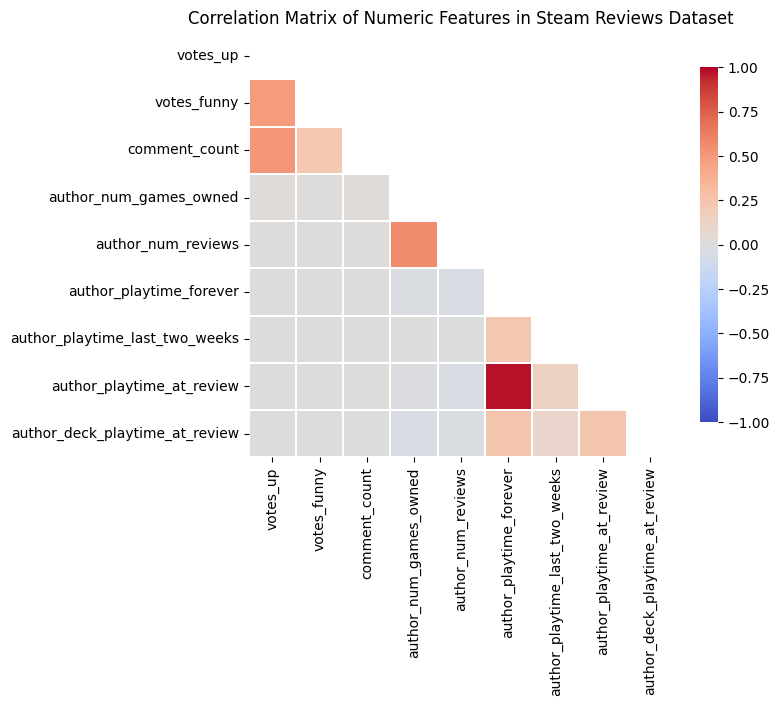

`author_playtime_forever` is highly positively correlated with `author_playtime_at_review` (0.97).


In [15]:
# Create correlation matrix for numeric columns only
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Plot the correlation matrix
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
cols = corr_matrix.columns
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=0.1,
    cbar_kws={'shrink': 0.6}
)
ax.set_xticks(np.arange(len(cols)) + 0.5) # Ensure every tick/label is shown 
ax.set_yticks(np.arange(len(cols)) + 0.5)
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(cols, rotation=0)
plt.tight_layout()
plt.title('Correlation Matrix of Numeric Features in Steam Reviews Dataset')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Get the absolute correlation matrix and set diagonal to 0 to ignore self-correlation
high_corr = corr_matrix.unstack().to_frame('correlation') # Unstack the correlation matrix
high_corr['sign'] = np.where(high_corr['correlation'] >= 0, 'positive', 'negative') # Add a new column indicating if the correlation is positive or negative
high_corr['correlation'] = high_corr['correlation'].abs().drop_duplicates()
high_corr = high_corr[high_corr['correlation'] < 1]
high_corr = high_corr.sort_values(by='correlation', ascending=False)
for (var1, var2), row in high_corr.head(1).iterrows():
    print(f"`{var1}` is highly {row['sign']}ly correlated with `{var2}` ({row['correlation']:.2f}).")


`author_playtime_forever` is highly positively correlated with `author_playtime_at_review` (0.97)--this is expected, as the total playtime should be at least as much as the playtime at the time of review.

We also verify that there are no duplicate rows in the dataset.

In [16]:
# Check duplicate rows
df_duplicates = df[df.duplicated()]
print(f"There are {df_duplicates.shape[0]:,} duplicate rows.")

There are 0 duplicate rows.


We also visualize the distribution of reviews over time.

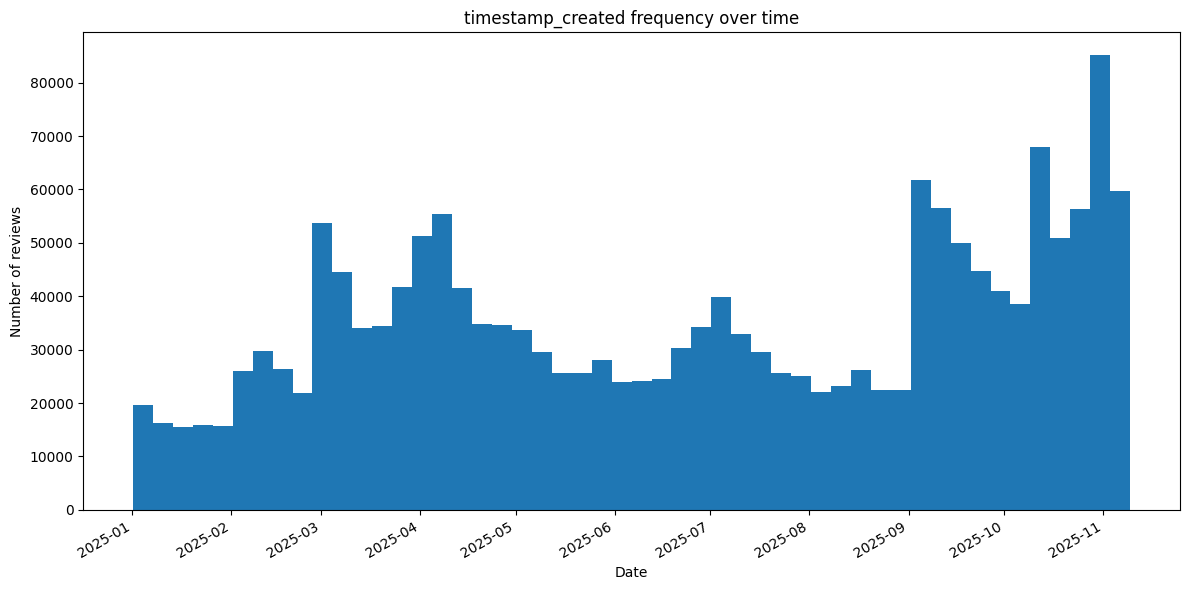

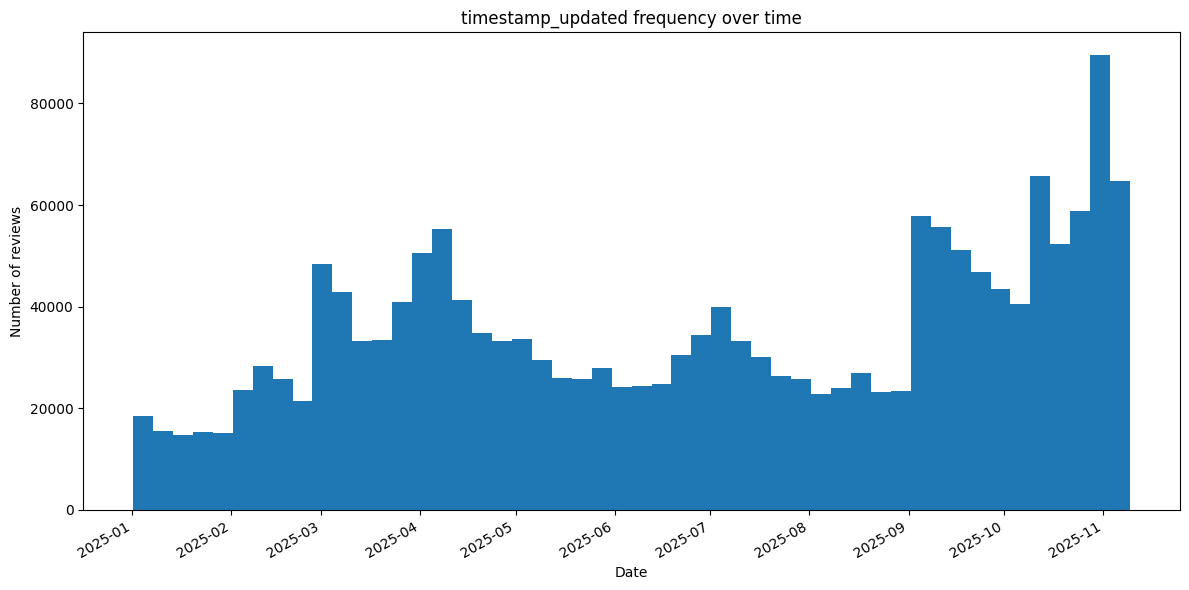

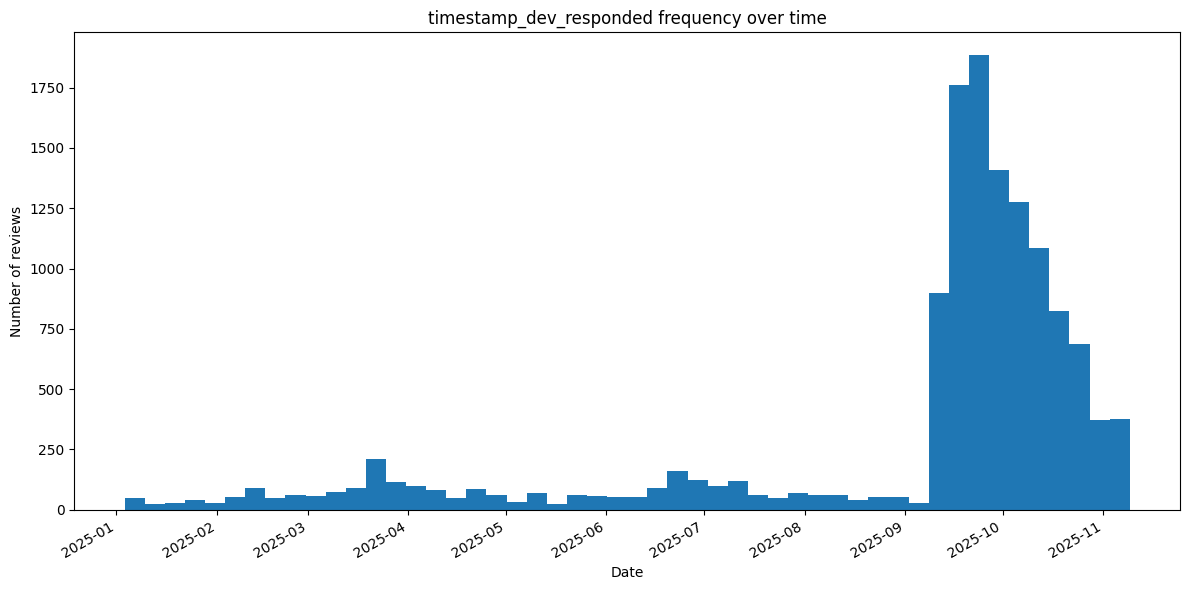

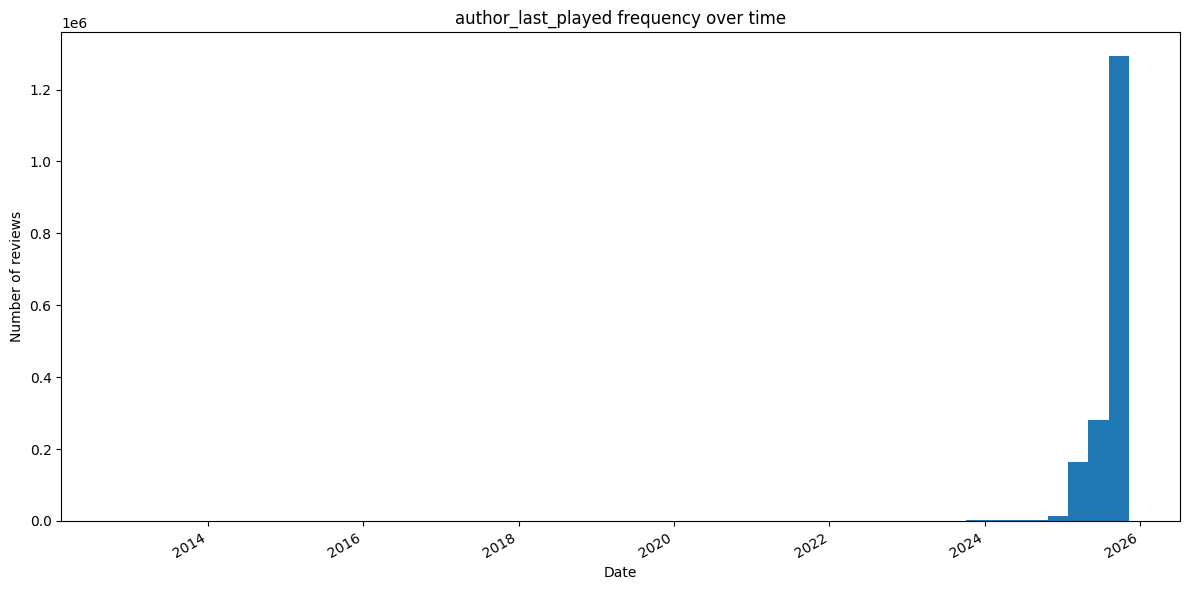

In [17]:
# Get datetime columns
timestamp_columns = ['timestamp_created', 'timestamp_updated', 'timestamp_dev_responded', 'author_last_played']
for col in timestamp_columns:
    # Histogram of review timestamps
    ts = df[col].dropna()
    plt.figure(figsize=(12,6))
    plt.hist(ts, bins=50)
    plt.xlabel('Date')
    plt.ylabel('Number of reviews')
    plt.title(f'{col} frequency over time')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

Reviews in this dataset start getting posted at the beginning of 2025. Some early outliers appear in `author_last_played`, where reviewers post a review for a game they last played up to a decade ago (min is October 9, 2012).

We also visualize the distribution of other numeric columns.

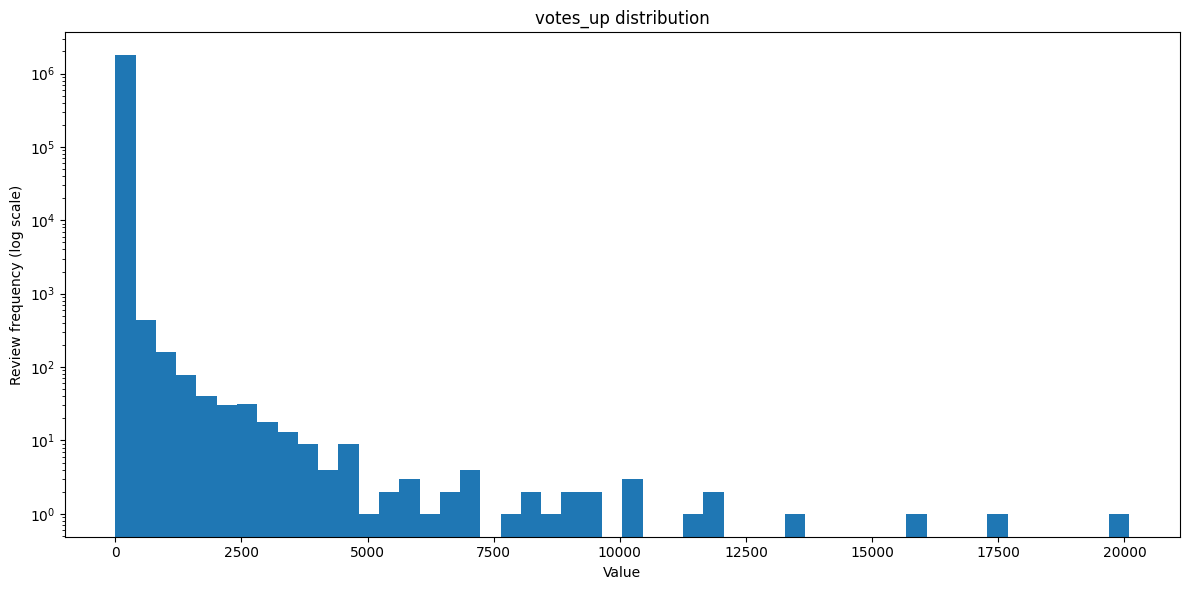

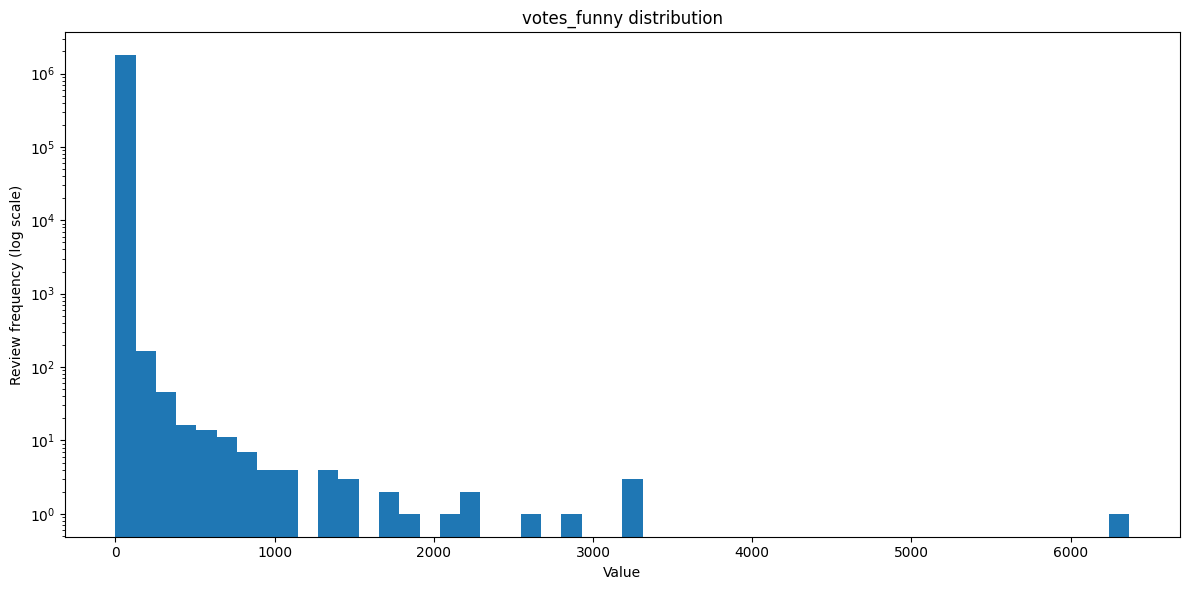

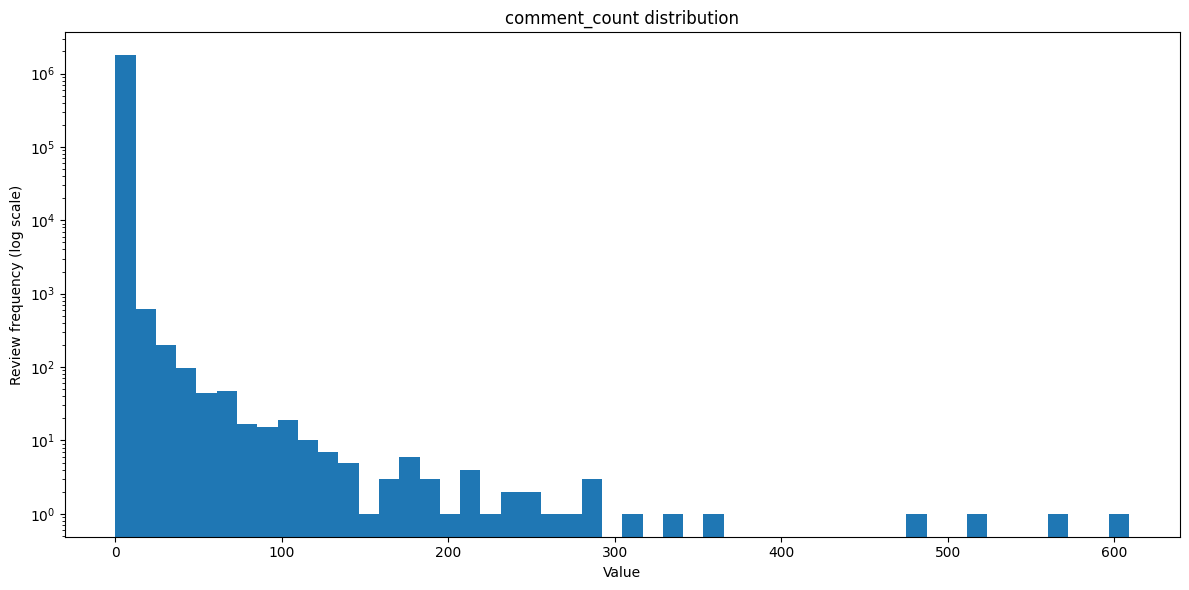

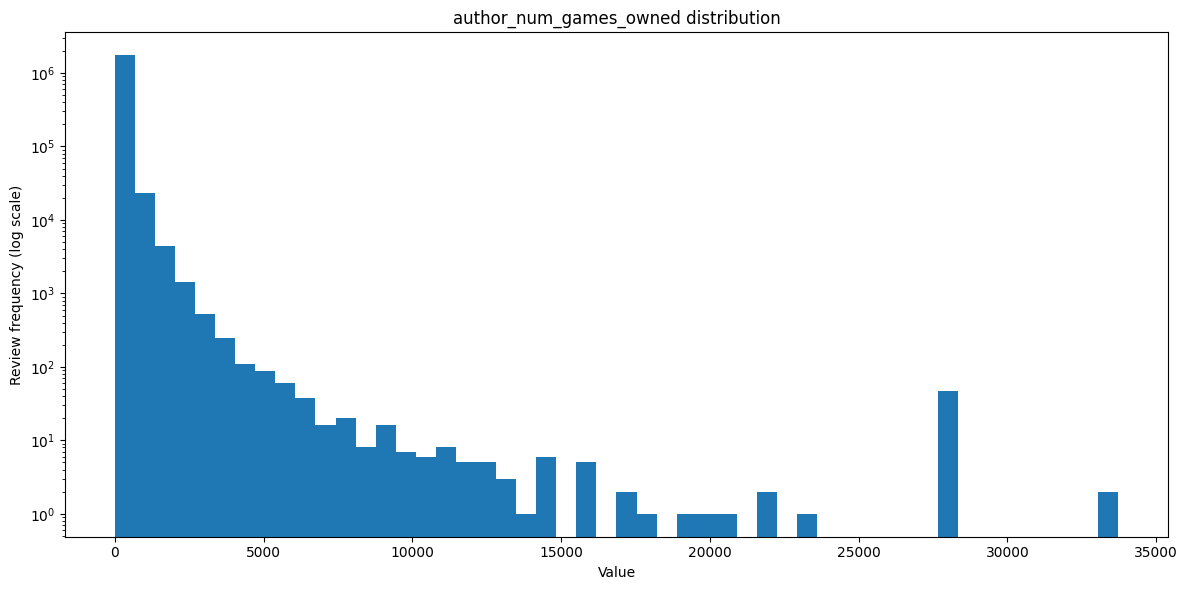

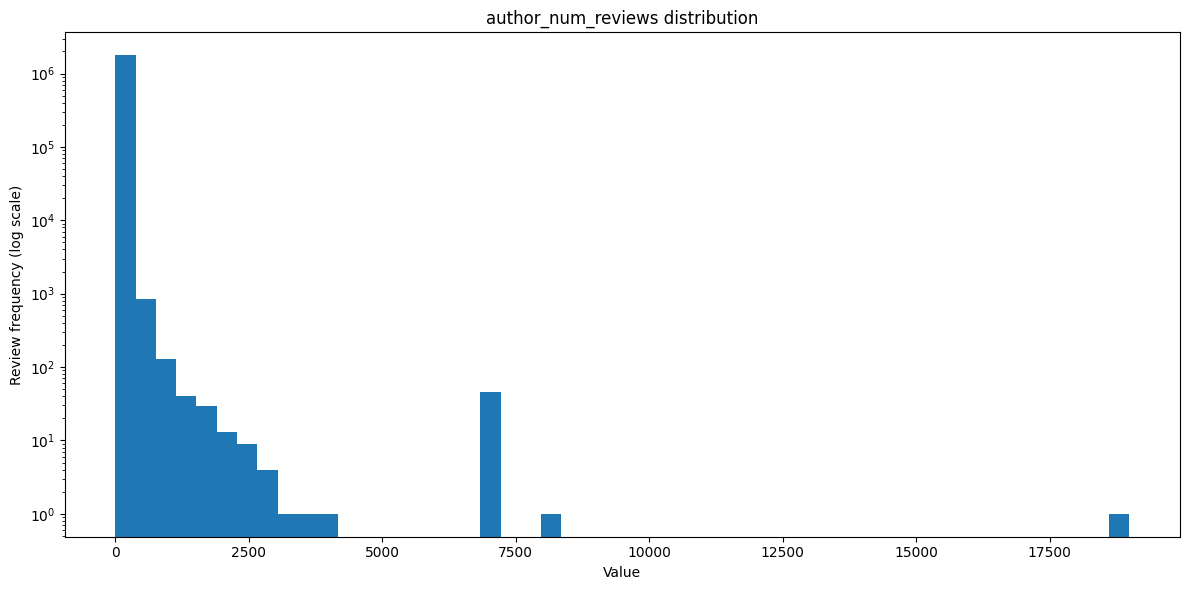

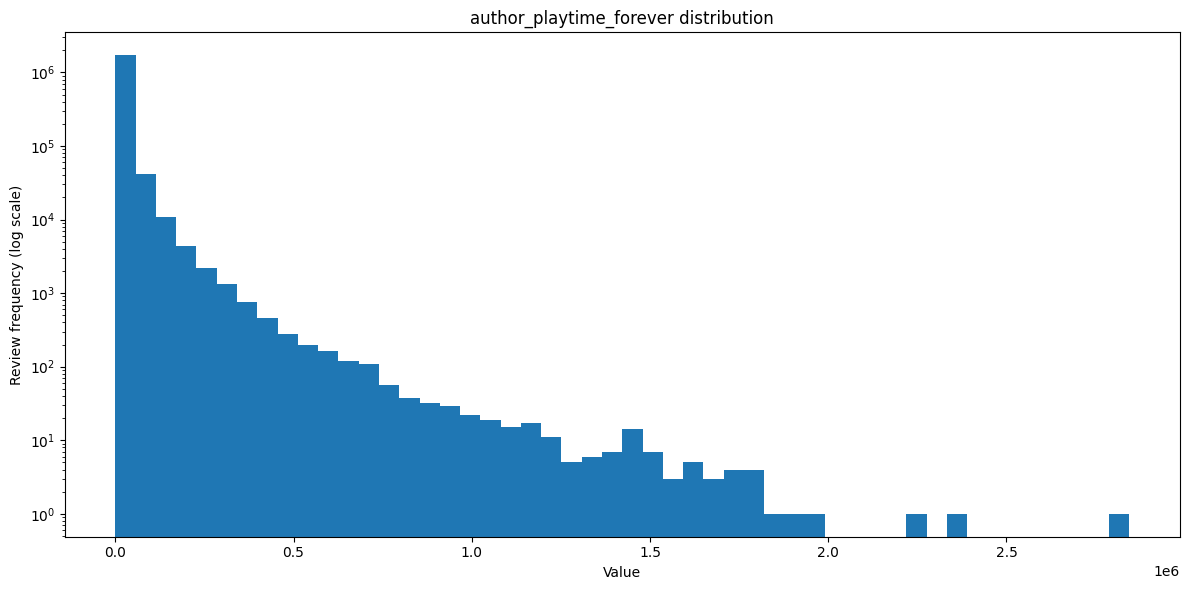

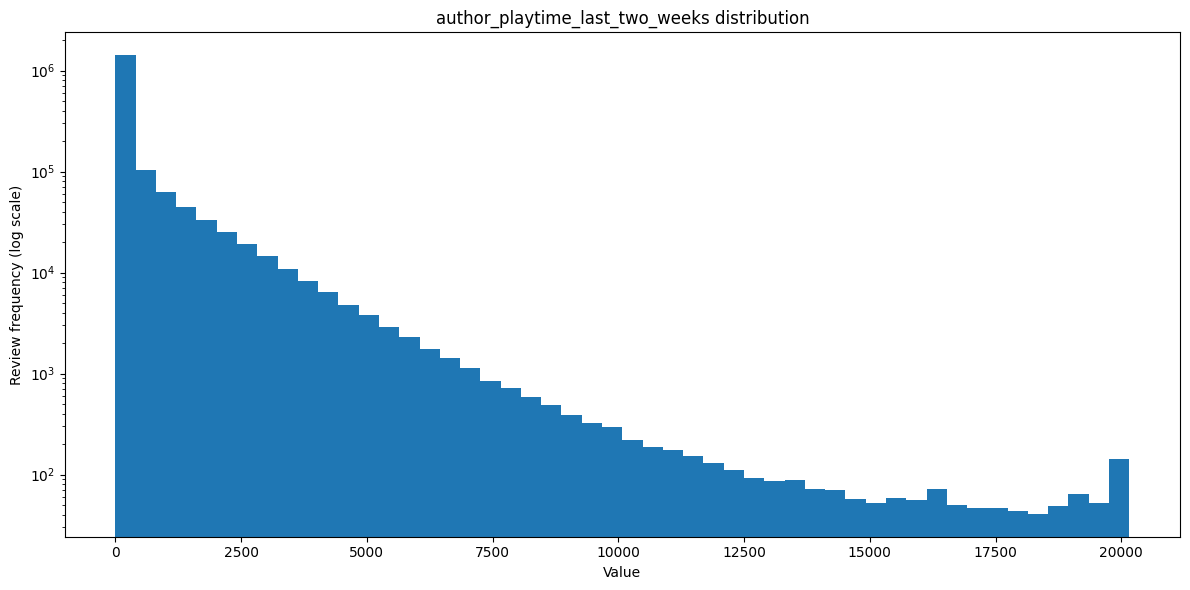

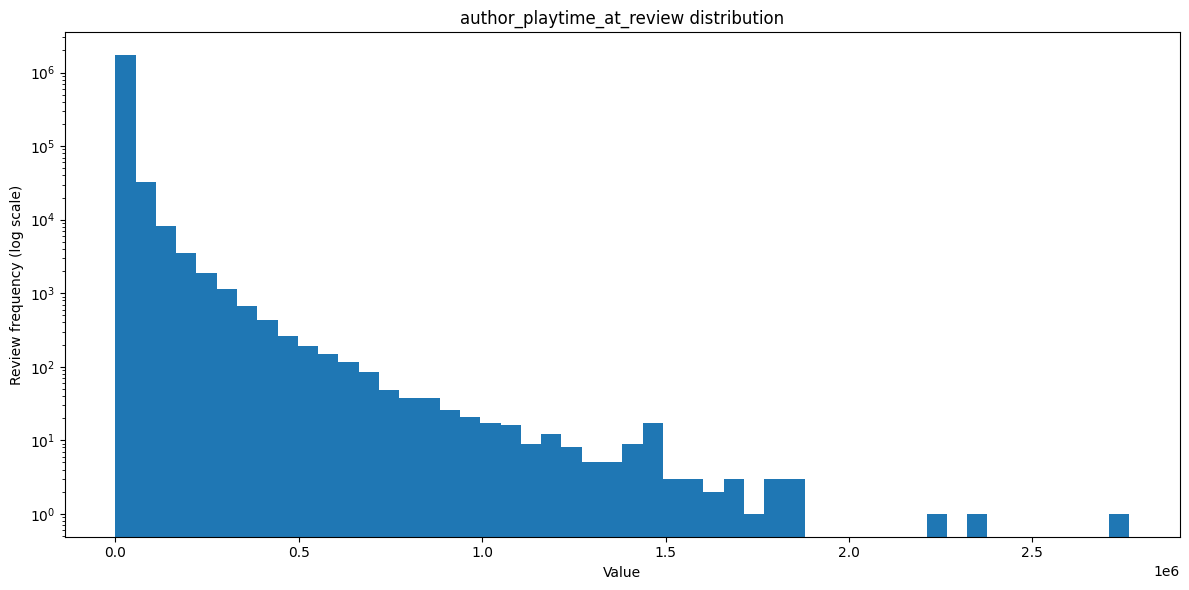

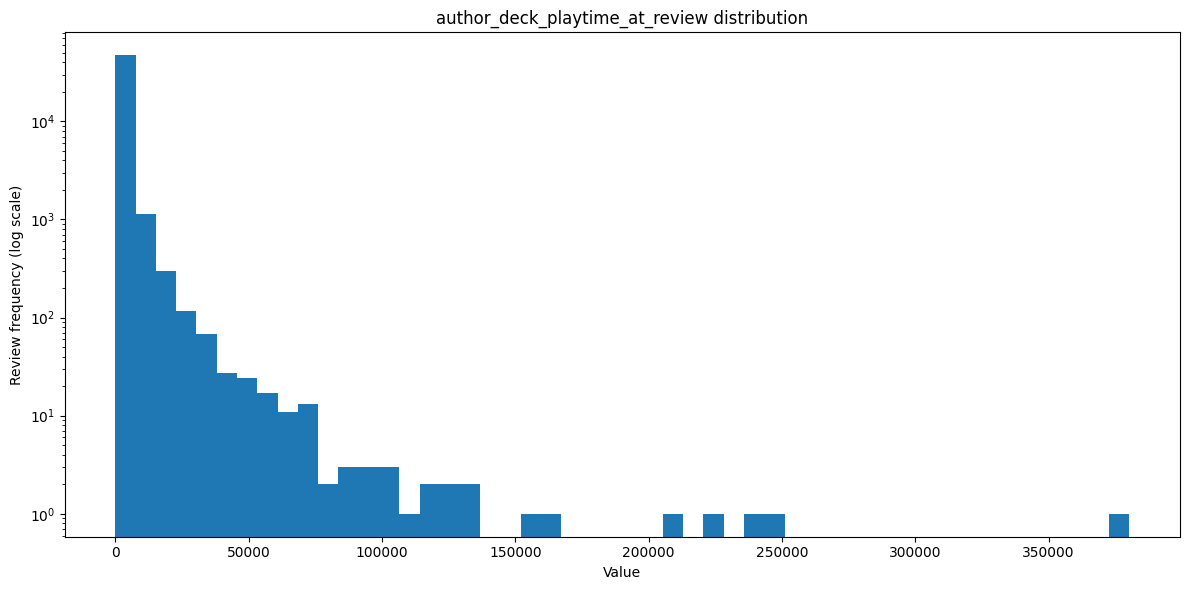

In [18]:
# Get numeric columns
numeric_columns = list(df.select_dtypes(include=[np.number]).columns)
for col in numeric_columns:
    # Histogram with exponential vertical axis (log scale)
    ts = df[col].dropna()
    if ts.empty:
        continue
    plt.figure(figsize=(12,6))
    plt.hist(ts, bins=50, log=True)
    plt.xlabel('Value')
    plt.ylabel('Review frequency (log scale)')
    plt.title(f'{col} distribution')
    plt.tight_layout()
    plt.show()

The number of upvotes, funny votes, and comments on reviews, as well as the playtime metrics, are all right-skewed, with most reviews having low values and a few reviews having very high values.

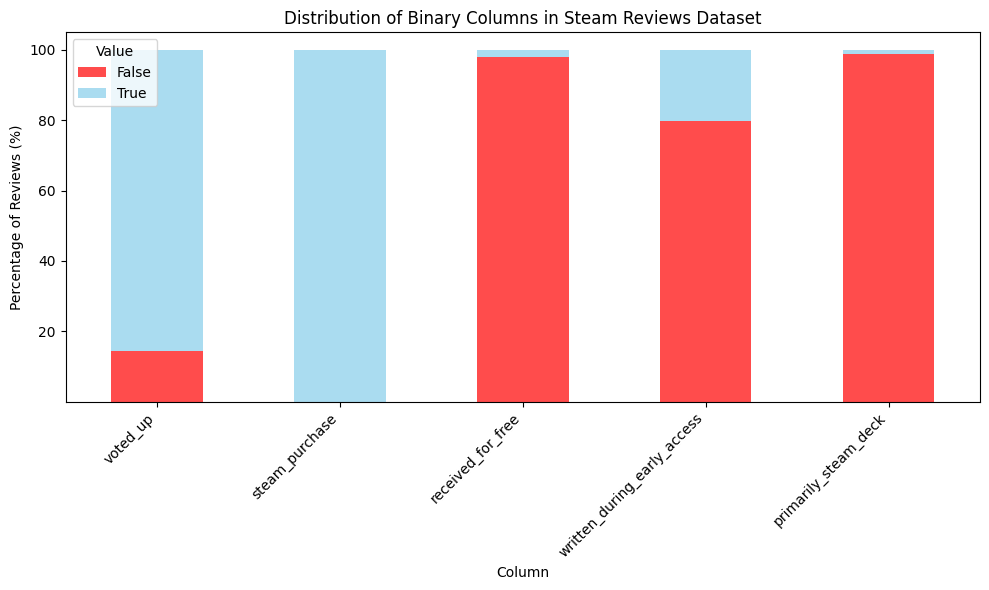

In [19]:
# Stacked bar chart for all binary columns
binary_columns = [col for col in df.columns if df[col].dropna().nunique() == 2]

# Compute percentages (of non-null values) for False/True for each binary column
false_counts = []
true_counts = []
for col in binary_columns:
    total = df[col].notnull().sum()
    if total == 0:
        false_counts.append(0.0)
        true_counts.append(0.0)
        continue
    false_counts.append(df[col].eq(False).sum() / total * 100)
    true_counts.append(df[col].eq(True).sum() / total * 100)

# Create DataFrame (remove unsupported kwargs from constructor)
counts_df = pd.DataFrame({'False': false_counts, 'True': true_counts}, index=binary_columns)

# Pass plotting color/alpha to the plot method instead
ax = counts_df.plot(kind='bar', stacked=True, figsize=(10,6), color=['red', 'skyblue'], alpha=0.7)
ax.set_xlabel('Column')
ax.set_ylabel('Percentage of Reviews (%)')
ax.set_title('Distribution of Binary Columns in Steam Reviews Dataset')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Value')
plt.tight_layout()
plt.show()

Many reviews had upvotes, almost all were purchased on Steam, most reviewers did not receive the game for free, about a fifth were written during early access of a game, and most reviewers did not play on a Steam Deck.

## Sentiment Analysis

With all of our reviews loaded we can now perform sentiment analysis on the data to determine how users feel about different games.

### Binary Sentiment Analysis

Starting off this analysis, we'll see which games have the most positive and negative reviews.

In [20]:
# Creating an empty dictionary to store reviews
review_ratios = {}

# Analyzing review sentiments
for review in all_reviews_data:
    t_app_id = review['game_appid']
    
    # Initialize the app ID entry if it doesn't exist
    if t_app_id not in review_ratios.keys():
        review_ratios[t_app_id] = {
            'rated_up': 0,
            'rated_down': 0,
            'percent_positive' : 0.0
        }

        # Map the app ID to its name
        review_ratios[t_app_id]['name'] = app_id_to_name_map[int(t_app_id)]

    # Increment the appropriate counter based on the review sentiment
    if review['voted_up']:
        review_ratios[t_app_id]['rated_up'] += 1
    else:
        review_ratios[t_app_id]['rated_down'] += 1

    # Calculating positive review ratios
    review_ratios[t_app_id]['percent_positive'] = (
        review_ratios[t_app_id]['rated_up'] /
        (review_ratios[t_app_id]['rated_up'] + review_ratios[t_app_id]['rated_down'])
    ) * 100.0

NameError: name 'app_id_to_name_map' is not defined

/var/folders/dc/lsr79y5d6g75qdx4_s0tt9nh0000gn/T/ipykernel_30625/3774200755.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/dc/lsr79y5d6g75qdx4_s0tt9nh0000gn/T/ipykernel_30625/3774200755.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/dc/lsr79y5d6g75qdx4_s0tt9nh0000gn/T/ipykernel_30625/3774200755.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/dc/lsr79y5d6g75qdx4_s0tt9nh0000gn/T/ipykernel_30625/3774200755.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

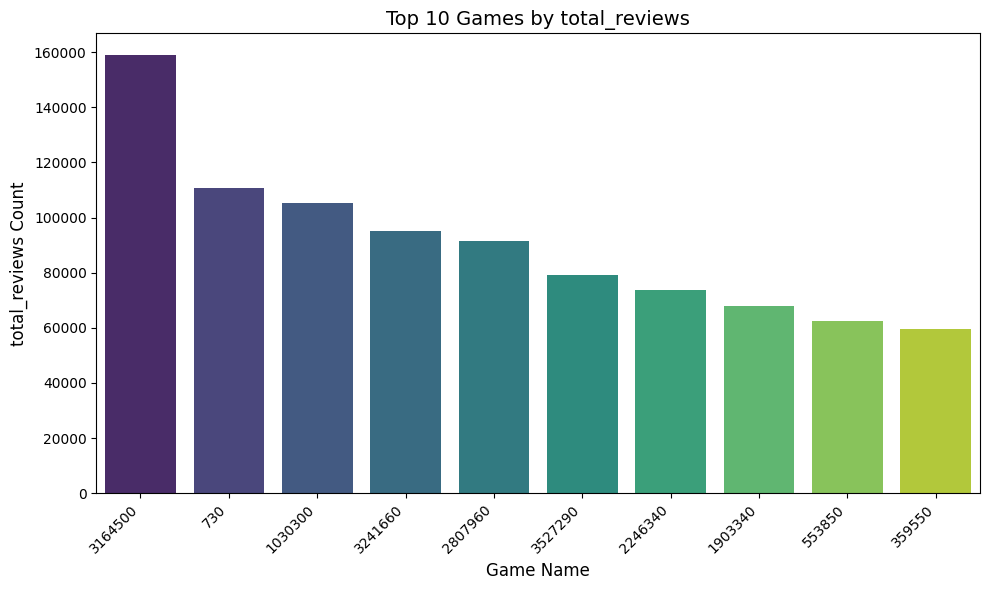

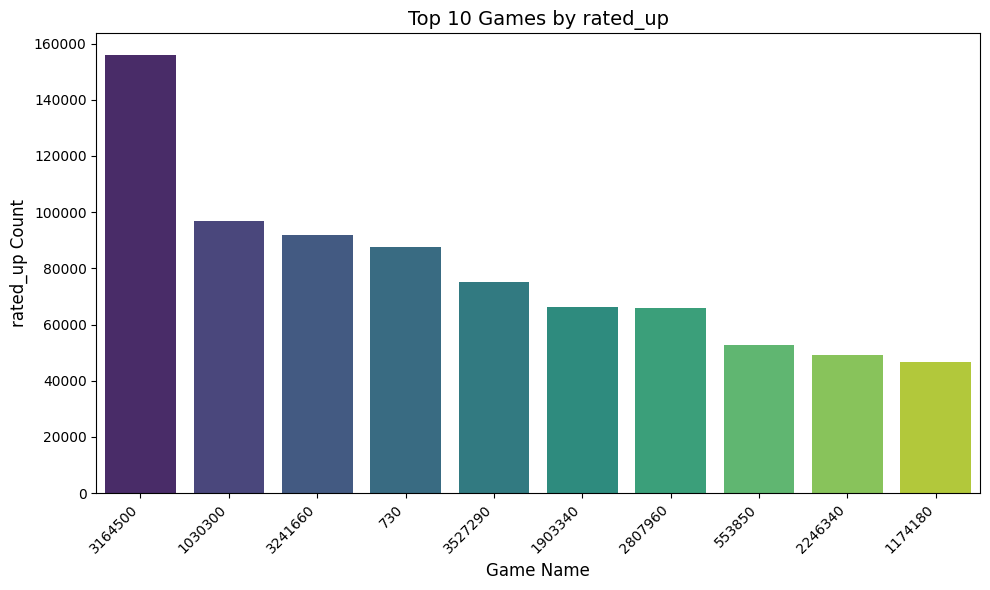

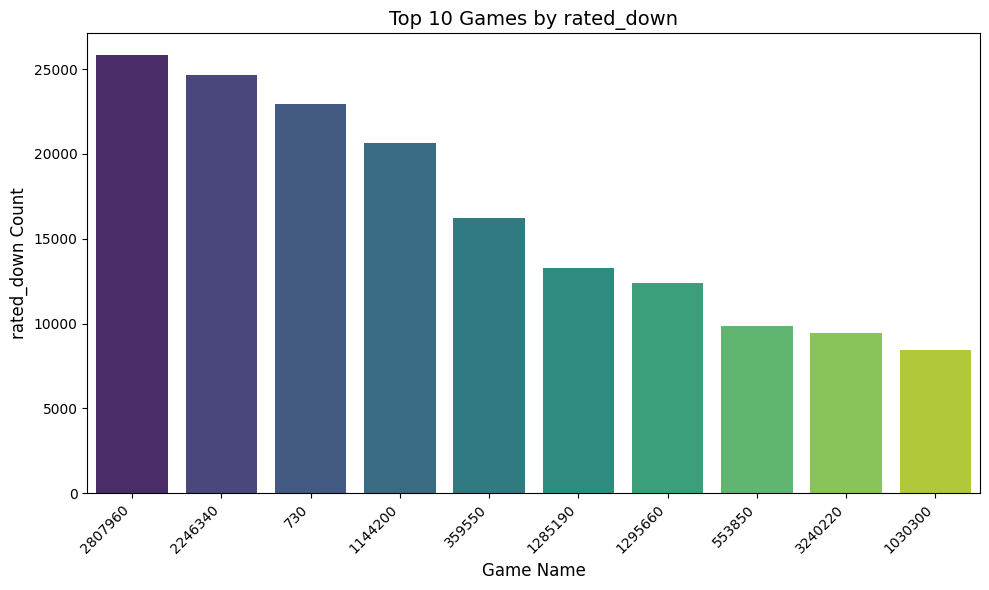

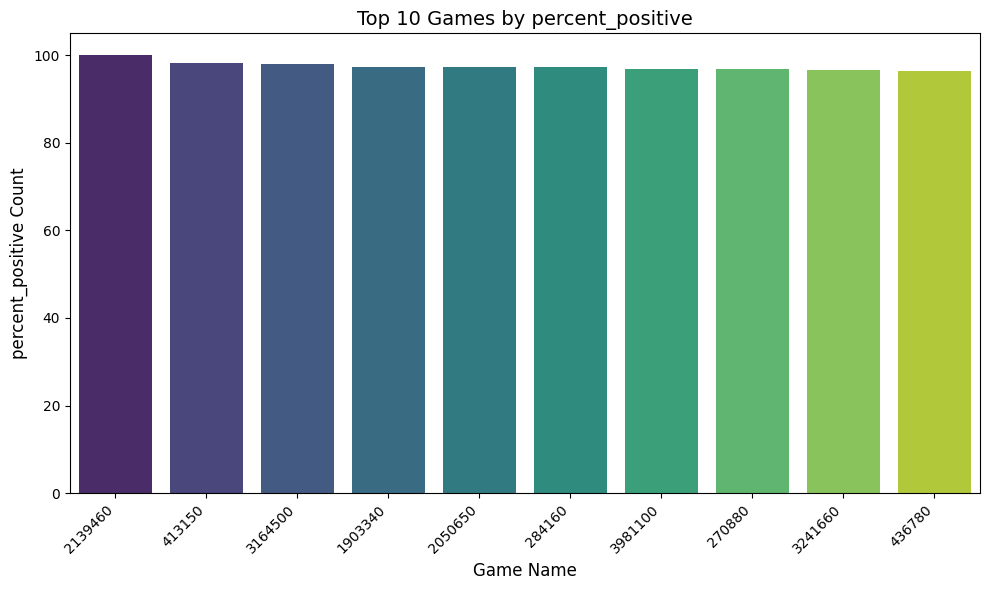

In [ ]:
# Creating a DataFrame for visualization
viz_1_df = pd.DataFrame.from_dict(review_ratios, orient='index')
viz_1_df.index.name = 'AppID'

viz_1_df['total_reviews'] = viz_1_df['rated_up'] + viz_1_df['rated_down']

metrics_to_plot = [
    'total_reviews',
    'rated_up',
    'rated_down',
    'percent_positive'
]

for metric in metrics_to_plot:
    t_viz_df = viz_1_df.copy().sort_values(by=metric, ascending=False).head(10).reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=t_viz_df,
        x='name', 
        y=metric,
        palette="viridis",
        order=t_viz_df['name'] 
    )

    plt.title(f'Top 10 Games by {metric}', fontsize=14)
    plt.xlabel('Game Name', fontsize=12)
    plt.ylabel(f'{metric} Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

We can see that there are a lot of differences between games in terms of user sentiment. Some games have a very high percentage of positive reviews, while others have a much lower percentage.

It's difficult to see the differences in `percent_positive` values in a bar chart, so let's try a histogram to get a better sense of the distribution.

array([[<Axes: title={'center': 'percent_positive'}>]], dtype=object)

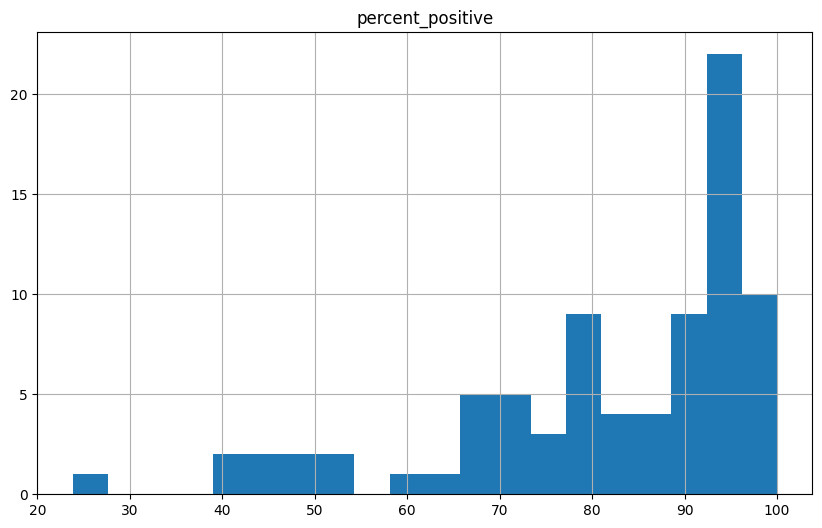

In [ ]:
viz_1_df.hist(
    column='percent_positive',
    bins=20,
    figsize=(10,6)
)

With a histogram we can see that the majority of games have a high percentage of positive reviews, with a smaller number of games having a lower percentage of positive reviews. This makes sense as it's the top 100 and the most popular games on Steam are likely to be well-liked by users.

### Text Analysis

For this section we'll go through the text of the reviews to see what words are most commonly used in positive and negative reviews. We'll attempt to find any patterns in the words used in reviews to see if there are any common themes among positive and negative reviews.

In [23]:
# Preparing review text data for analysis
review_text = []

# Extracting relevant fields from each review
for review in all_reviews_data:
    # Append a tuple of (App ID, Sentiment, Review Text)
    review_text.append(
        (
            review['game_appid'],
            1 if review['voted_up'] else 0,
            review['review']
        )
    )

# Summary of collected reviews
print(f"There are {len(review_text):,} reviews collected for text analysis.")

There are 1,774,962 reviews collected for text analysis.


In [24]:
# Function to clean review text
def clean_text(text):
    # Prepare stop words
    stop_words = set(stopwords.words('english'))

    # Remove non-alphabetic characters and convert to lower case
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    
    # Tokenize the text
    filtered_words = [
        word for word in word_tokenize(text) 
        if word.isalpha() and word not in stop_words
    ]

    return filtered_words

# Separate positive and negative reviews and clean the text
positive_reviews = clean_text(' '.join([text for appid, sentiment, text in review_text if sentiment == 1]))
negative_reviews = clean_text(' '.join([text for appid, sentiment, text in review_text if sentiment == 0]))

In [25]:
# # Calculate document frequency for positive reviews
positive_reviews_dict = {}
for word in positive_reviews:
    if word in positive_reviews_dict:
        positive_reviews_dict[word] += 1
    else:
        positive_reviews_dict[word] = 1

pos_df = pd.DataFrame.from_dict(positive_reviews_dict, orient='index', columns=['doc_frequency'])
pos_df = pos_df.sort_values(by='doc_frequency', ascending=False)

# Calculate document frequency for negative reviews
negative_reviews_dict = {}
for word in negative_reviews:
    if word in negative_reviews_dict:
        negative_reviews_dict[word] += 1
    else:
        negative_reviews_dict[word] = 1

neg_df = pd.DataFrame.from_dict(negative_reviews_dict, orient='index', columns=['doc_frequency'])
neg_df = neg_df.sort_values(by='doc_frequency', ascending=False)

In [27]:
pos_df.head()

,doc_frequency
game,1040656
good,271573
fun,268791
like,216564
play,159039


In [28]:
neg_df.head()

,doc_frequency
game,373741
like,96985
play,68373
get,62284
even,61623


From the above, we can see that there are a few common words in both positive and negative reviews such as "game" and "play". However, there are also some words that are more common in positive reviews such as "good",  and "fun".

To try to visualize the differences better, we'll try to remove any common words in the top 1000 words across both positive and negative reviews. This will help us to see the differences in the words used in positive and negative reviews more clearly.

With this data, we'll generate word clouds to visualize the most common words in positive and negative reviews.

In [29]:
# Removing common words in the top 1000 across both positive and negative reviews
filtered_pos_df = pos_df[~pos_df.index.isin(neg_df.head(1000).index)]
filtered_neg_df = neg_df[~neg_df.index.isin(pos_df.head(1000).index)]

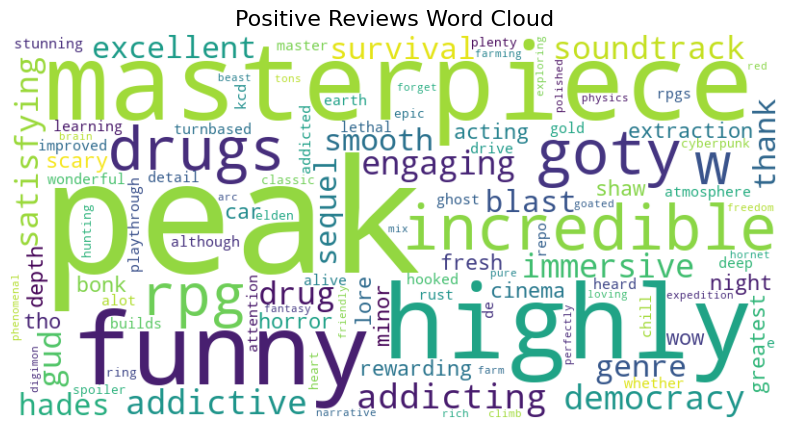

In [30]:
# Configuration settings
wc_config = dict(
    width=800, 
    height=400, 
    background_color='white', 
    min_font_size=10
)

# Generate the word cloud directly from the frequency dictionary
wordcloud = WordCloud(**wc_config).generate_from_frequencies(filtered_pos_df.to_dict()['doc_frequency'])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud', fontsize=16)
plt.axis('off')
plt.show()

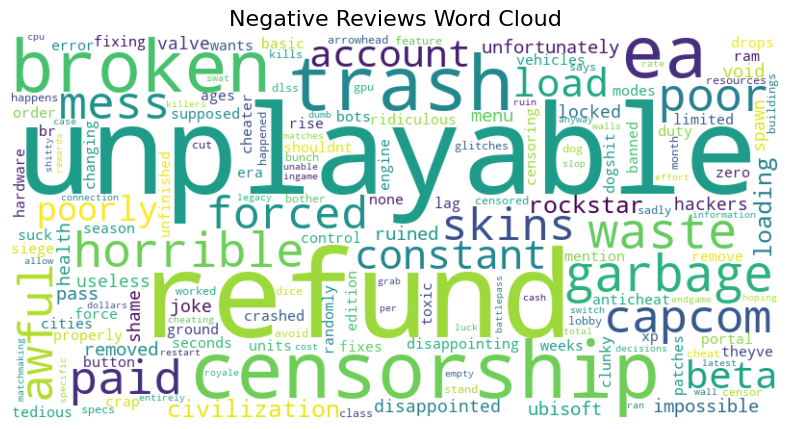

In [31]:
# Configuration settings
wc_config = dict(
    width=800, 
    height=400, 
    background_color='white', 
    min_font_size=10
)

# Generate the word cloud directly from the frequency dictionary
wordcloud = WordCloud(**wc_config).generate_from_frequencies(filtered_neg_df.to_dict()['doc_frequency'])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud', fontsize=16)
plt.axis('off')
plt.show()

This was much more insightful. Asking for a refund is a common theme in negative reviews, while words like "peak" and "masterpiece" are common in positive reviews. This gives us a better sense of the themes present in positive and negative reviews on Steam.

Additionally, we can see in the negative reviews that there's a theme of added costs such as "skins" and "paid", assumingly referring to in-game purchases that users are unhappy about. A quick call out as it seems that Rockstar Games titles have a lot of negative reviews, potentially due to the controversy around GTA Online and its microtransactions.

## Network Analysis for Reviewers

In this section, we'll perform a network analysis on the reviewers to see if there are any "super" reviewers who may influence the overall sentiment of reviews for certain games. 

### Network Construction

First, we'll construct a bipartite graph where one set of nodes represents reviewers and the other set represents games. An edge will exist between a reviewer and a game if the reviewer has left a review for that game.

In [ ]:
# Select relevant columns for network analysis: authors and games, where each row is a review
df_auth_games = df[['author_steamid', 'game_appid']]

# Create the bipartite graph: nodes are characters and pages, edges connect characters to pages they appear on
B = nx.Graph()
authors = set(df_auth_games['author_steamid']).union(set(df_auth_games['game_appid']))
games = set(df_auth_games['game_appid'])

for _, row in df_auth_games.iterrows():
    B.add_edge(row['author_steamid'], row['game_appid'])
# Get the character and page node lists (as in the bipartite sets)
author_list = sorted(authors)
game_list = sorted(games)

print("Biadjacency matrix")
print(bi.biadjacency_matrix(B, author_list, game_list))

The biadjacency matrix shows there are 1,505,778 authors (represented as rows) and 82 unique games (represented as columns) in the dataset. There are 4,600 edges between authors and games. Coord (153, 81) with a value of 1 (binary indicator that the author reviewed that game) represents author 153 reviewing game 81, for example.

We projected this bipartite data into a network of author nodes. In the author network, two authors are connected by an edge if and only if they reviewed the same game at least once.

In [ ]:
# Get the actual author nodes (exclude game nodes)
actual_authors = set(df_auth_games['author_steamid'])
author_nodes = sorted(actual_authors)

# Project the bipartite graph to create the author-author network
author_network = bi.weighted_projected_graph(B, author_nodes)

### Core Network Analysis

We visualize part of the author network using the island method below.

## Data Dictionary
- `recommendationid` - The unique id of the recommendation
- `author_steamid` - the user’s SteamID
- `author_num_games_owned` - number of games owned by the user
- `author_num_reviews` - number of reviews written by the user
- `author_playtime_forever` - lifetime playtime tracked in this app
- `author_playtime_last_two_weeks` - playtime tracked in the past two weeks for this app
- `author_playtime_at_review` - playtime when the review was written
- `author_deck_playtime_at_review` - playtime on Steam Deck when the review was written
- `author_last_played` - time for when the user last played
- `language` - language the user indicated when authoring the review
- `review` - text of written review
- `timestamp_created` - date the review was created (unix timestamp)
- `timestamp_updated` - date the review was last updated (unix timestamp)
- `voted_up` - true means it was a positive recommendation
- `votes_up` - the number of users that found this review helpful
- `votes_funny` - the number of users that found this review funny
- `weighted_vote_score` - helpfulness score
- `comment_count` - number of comments posted on this review
- `steam_purchase` - true if the user purchased the game on Steam
- `received_for_free` - true if the user checked a box saying they got the app for free
- `written_during_early_access` - true if the user posted this review while the game was in Early Access
- `developer_response` - text of the developer response, if any
- `timestamp_dev_responded` - Unix timestamp of when the developer responded, if applicable
- `primarily_steam_deck` - Did the reviewer play this game primarily on Steam Deck at the time of writing'